### 1. Aggregate the tornado data over the following states into a monthly count of tornadoes: Illinois

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

/Users/wenhant2/.conda/envs/shap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("1950-2021_actual_tornadoes.csv")
df_illinois = df[ df["st"] == "IL" ].copy()
df_illinois["date"] = pd.to_datetime(df_illinois["date"])
df_illinois["year_month"] = df_illinois["date"].dt.to_period("M")

df_illinois_monthly = df_illinois.groupby("year_month").size()

df_illinois_monthly = df_illinois_monthly.reindex(
    pd.period_range(
        df_illinois_monthly.index.min(),
        df_illinois_monthly.index.max(),
        freq='M'
    ),
    fill_value=0
).reset_index(name="tornados")
df_illinois_monthly = df_illinois_monthly.rename(columns = {"index": "year_month"})
df_illinois_monthly

,year_month,tornados
0,1950-01,2
1,1950-02,0
2,1950-03,1
3,1950-04,0
4,1950-05,0
...,...,...
859,2021-08,16
860,2021-09,0
861,2021-10,10
862,2021-11,0


### 2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [3]:
df_ts = pd.read_csv("ts_data2.csv").reset_index()
df_ts = df_ts.rename(columns={"Date": "date"})
df_ts = df_ts[["date", "ENSO", "PDO", "NAO", "AO"]]
df_ts["date"] = pd.to_datetime(df_ts["date"])
df_ts["year_month"] = df_ts["date"].dt.to_period("M")
df_ts

,date,ENSO,PDO,NAO,AO,year_month
0,1854-01-01,NaN,0.11,NaN,NaN,1854-01
1,1854-02-01,NaN,-0.24,NaN,NaN,1854-02
2,1854-03-01,NaN,-0.40,NaN,NaN,1854-03
3,1854-04-01,NaN,-0.44,NaN,NaN,1854-04
4,1854-05-01,NaN,-0.54,NaN,NaN,1854-05
...,...,...,...,...,...,...
2059,2025-08-01,0.4,-3.20,0.26,0.036,2025-08
2060,2025-09-01,0.0,-2.33,-0.80,0.048,2025-09
2061,2025-10-01,-99.9,-2.40,-0.96,0.064,2025-10
2062,2025-11-01,-99.9,99.99,NaN,NaN,2025-11


In [4]:
df_merged = df_illinois_monthly.merge(df_ts[["year_month", "ENSO", "PDO", "NAO", "AO"]], on="year_month", how="left")
df_merged["year_month"] = df_merged["year_month"].dt.to_timestamp()
df_merged = df_merged.set_index("year_month")
df_merged

,tornados,ENSO,PDO,NAO,AO
year_month,,,,,
1950-01-01,2,NaN,-1.61,0.92,-0.060
1950-02-01,0,NaN,-2.17,0.40,0.627
1950-03-01,1,NaN,-1.89,-0.36,-0.008
1950-04-01,0,NaN,-1.99,0.73,0.555
1950-05-01,0,NaN,-3.19,-0.59,0.072
...,...,...,...,...,...
2021-08-01,16,0.6,-0.95,-0.28,-0.209
2021-09-01,0,0.8,-1.96,-0.21,-0.252
2021-10-01,10,0.7,-3.13,-2.29,-0.146


### 3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes. Create a scatter plot of the predicted and observed number of tornadoes over these states. Report the correlation coefficient and RMSE of your model.

In [5]:
df_Xy = df_merged.dropna()
X = df_Xy[["ENSO", "PDO", "NAO", "AO"]]
y = df_Xy["tornados"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [6]:
model_RF = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = 10,
    bootstrap = True,
    random_state = 0,
)
model_RF.fit(X_train, y_train.values)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


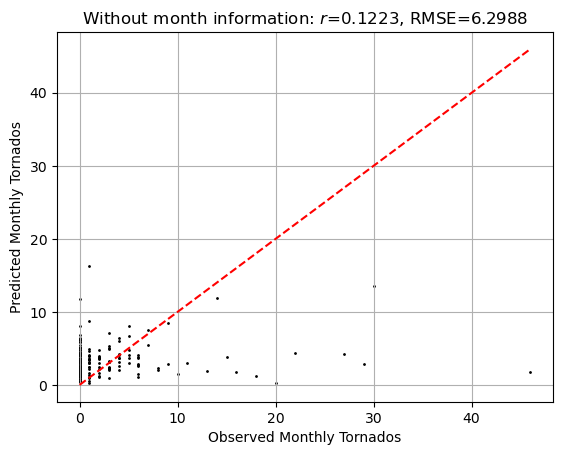

In [7]:
y_pred = model_RF.predict(X_test)
rr = np.corrcoef(y_pred, y_test.values)[0,1]
rmse = np.sqrt(mean_squared_error(y_pred, y_test.values))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test.values, y_pred, s=1, c="black")
min_range = min(y_test.values.min(), y_pred.min())
max_range = max(y_test.values.max(), y_pred.max())
ax.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="dashed")
ax.grid()
ax.set_xlabel("Observed Monthly Tornados")
ax.set_ylabel("Predicted Monthly Tornados")
ax.set_title(f"Without month information: $r$={rr:.4f}, RMSE={rmse:.4f}")
plt.show()

### 4. Create a one-hot encoding for the month of the year. Repeat the scatterplot and compare the RMSE and correlation coefficient values.

In [8]:
months = df_Xy.index.month
onehot_month = pd.get_dummies(months, prefix="month", drop_first=False)
onehot_month.index = df_Xy.index
X = X.merge(onehot_month, left_index=True, right_index=True, how="left")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [9]:
model_RF_month = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = 10,
    bootstrap = True,
    random_state = 0,
)
model_RF_month.fit(X_train, y_train.values)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


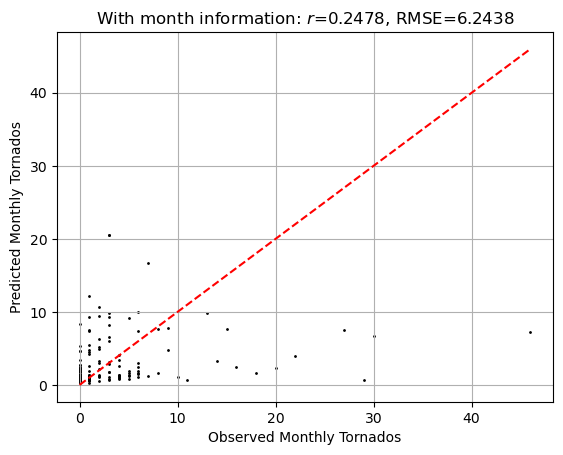

In [10]:
y_pred = model_RF_month.predict(X_test)
rr = np.corrcoef(y_pred, y_test.values)[0,1]
rmse = np.sqrt(mean_squared_error(y_pred, y_test.values))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test.values, y_pred, s=1, c="black")
min_range = min(y_test.values.min(), y_pred.min())
max_range = max(y_test.values.max(), y_pred.max())
ax.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="dashed")
ax.grid()
ax.set_xlabel("Observed Monthly Tornados")
ax.set_ylabel("Predicted Monthly Tornados")
ax.set_title(f"With month information: $r$={rr:.4f}, RMSE={rmse:.4f}")
plt.show()

### 5. Perform a feature importance and multipass permutation analysis of your features

Text(0.5, 1.0, 'Feature importance for random forest model (with month information)')

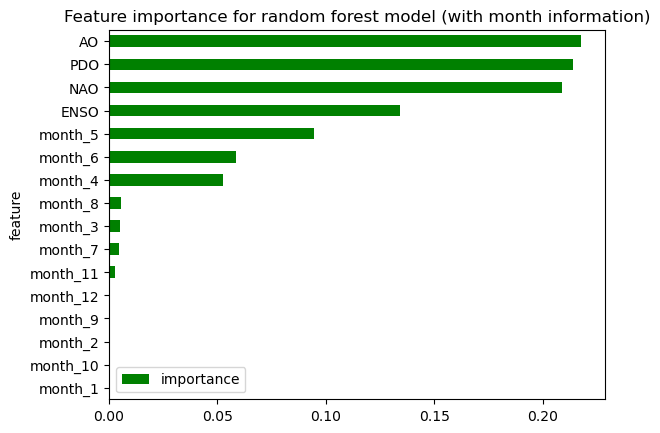

In [11]:
df_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": model_RF_month.feature_importances_,
})
df_importance = df_importance.sort_values("importance", ascending=True)
ax = df_importance.plot.barh(x="feature", y="importance", color="green")
ax.set_title("Feature importance for random forest model (with month information)")

In [12]:
result = permutation_importance(
    model_RF_month, X_test, y_test, n_repeats=20, random_state=0, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

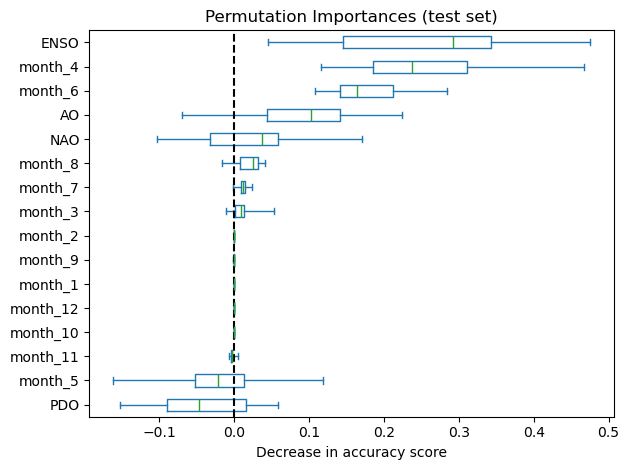

In [13]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 6. Create a SHAP Summary Plot showing feature importance and feature effects.

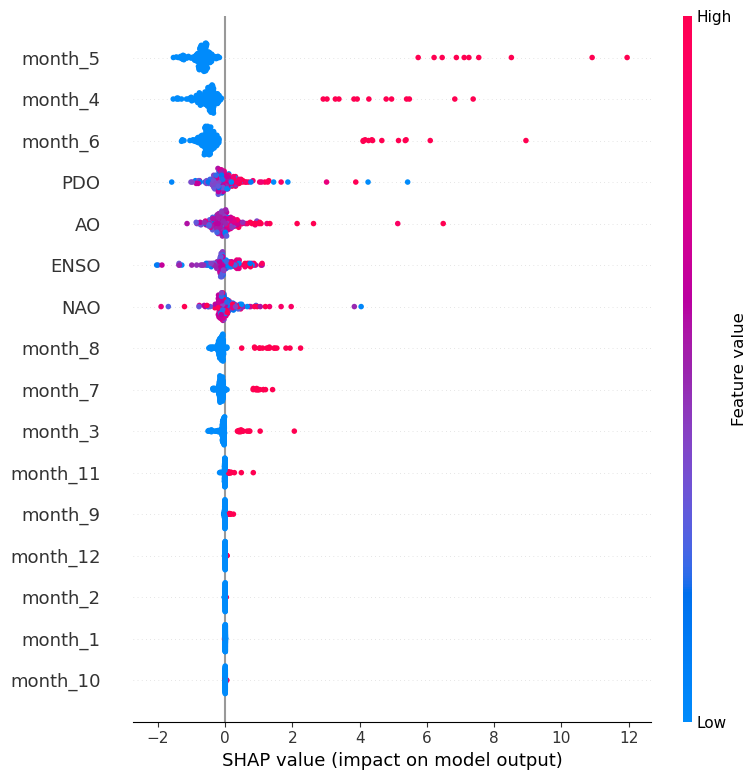

In [14]:
explainer_RF_month = shap.TreeExplainer(model_RF_month)
explain_values = explainer_RF_month.shap_values(X_test)
shap.summary_plot(explain_values, X_test)

### 7. Create a SHAP Feature Dependence for the ENSO index.

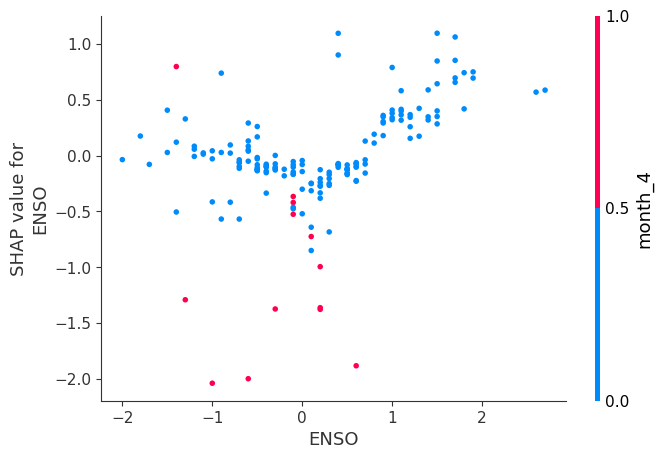

In [15]:
shap.dependence_plot("ENSO", explain_values, X_test)